# Simulation of Complex Systems - Chapter 5

Artur Gasparyan

## Exercise 5.1

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [24]:
n_steps = 1000
n_walks = 10000
sim_size = n_walks, n_steps

rng = np.random.default_rng()

outcomes_bernoulli = rng.choice([-1, 1], sim_size)
outcomes_gaussian = rng.normal(size=sim_size)
outcomes_asymmetry = rng.choice(
    [-1, (1-math.sqrt(3))/2, (1+math.sqrt(3))/2], size=sim_size
)

outcomes_all = outcomes_bernoulli, outcomes_gaussian, outcomes_asymmetry
trajectories_all = tuple(np.cumsum(o, axis=1) for o in outcomes_all)

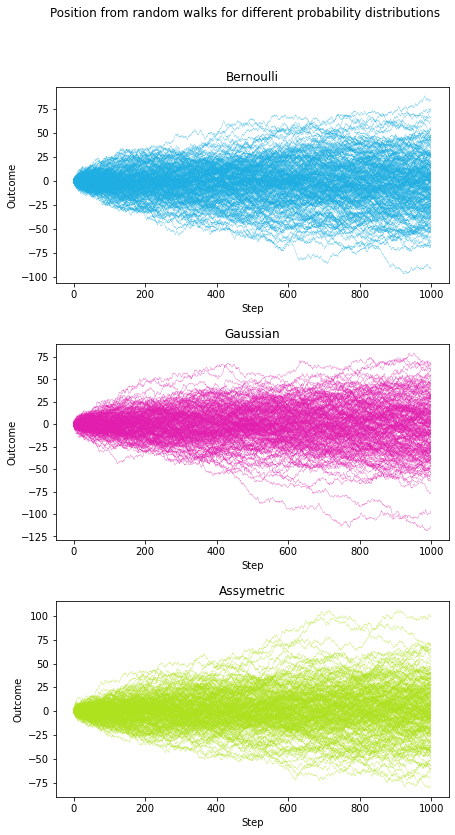

In [41]:
fig, axes = plt.subplots(3, 1, figsize=(7, 12))
fig.suptitle("Position from random walks for different probability distributions")
titles = ["Bernoulli", "Gaussian", "Assymetric"]
colors = ["#1EAEE1", "#E11EAE", "#AEE11E"]
fig.tight_layout(pad=4)

for trajectory, axis, title, color in zip(trajectories_all, axes, titles, colors):
    axis.plot(np.arange(n_steps), trajectory[:200].T, linewidth=0.25, color=color);
    axis.set_xlabel("Step")
    axis.set_ylabel("Outcome")
    axis.set_title(title)
    


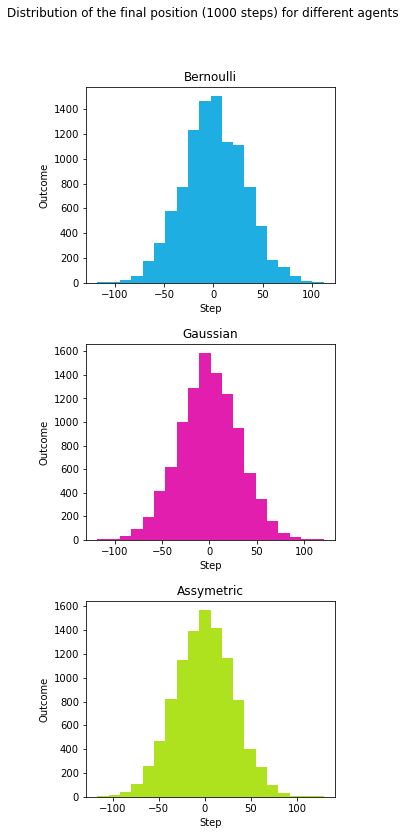

In [65]:
fig, axes = plt.subplots(3, 1, figsize=(5, 12))
fig.suptitle("Distribution of the final position (1000 steps) for different agents")
titles = ["Bernoulli", "Gaussian", "Assymetric"]
colors = ["#1EAEE1", "#E11EAE", "#AEE11E"]
fig.tight_layout(pad=4)

for trajectory, axis, title, color in zip(trajectories_all, axes, titles, colors):  
    axis.hist(trajectory[:, -1], 20, color=color)
    axis.set_xlabel("Step")
    axis.set_ylabel("Outcome")
    axis.set_title(title)